# TALOS Optimization - FOUR

An implementation of a hyperparameter grid search using the Talos library.

## Import Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import talos

### Check what hardware is available to Keras

In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8240830078219759046
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8280149956530184838
physical_device_desc: "device: XLA_CPU device"
]


## Load and Split Data

In [15]:
if True:
    keep_col = list(range(1,18))

    df_day = pd.read_csv('ECL_Clean_Day.csv', 
                     infer_datetime_format=True,
                     parse_dates=['Timestamp'], 
                     index_col=['Timestamp'],
                     usecols = keep_col,
                     date_parser=lambda col: pd.to_datetime(col, utc=True).tz_convert('America/New_York'))

    #df_min.dtypes
    print (df_day.shape)
    df_day.head(5)

(5031, 16)


In [16]:
# create 10 years of data from 2019 - 2010
day_data = df_day[df_day.index >= '2010-01-01']

#split 7 years train, 3 years test
day_train = day_data[day_data.index <= '2017-01-01']
day_test = day_data[day_data.index >= '2017-01-01']

In [17]:
base_train = day_train['Close'] 
base_test = day_test['Close']

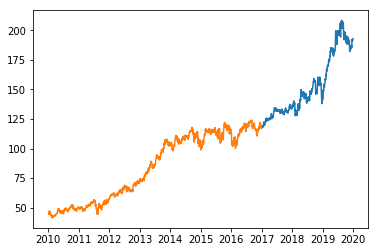

In [18]:
plt.plot(base_test)
plt.plot(base_train)
plt.show()

## Demonstrate Simple Vanilla Implementation

In [19]:
# Multi-step data preparation

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# define input sequence
#raw_seq = list(base_test[:100].values)
# choose a number of time steps
n_steps_in, n_steps_out = 30, 30
# split into samples
X_train, y_train = split_sequence(base_train.values, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(base_test.values, n_steps_in, n_steps_out) #length must be > n_in + n_out
# summarize the data
#for i in range(len(X)):
#    print(X[i], y[i])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1703, 30) (1703, 30) (695, 30) (695, 30)


In [20]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
#print (X_train.shape)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
#print (X_test.shape)

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.summary()

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1, shuffle=False)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_3 (Dense)              (None, 30)                3030      
Total params: 43,830
Trainable params: 43,830
Non-trainable params: 0
_________________________________________________________________
Train on 1703 samples, validate on 695 samples
Epoch 1/20
1703/1703 [==============================] - 3s 2ms/step - loss: 1765.6345 - val_loss: 819.9287
Epoch 2/20
1703/1703 [==============================] - 2s 1ms/step - loss: 179.8529 - val_loss: 189.0207
Epoch 3/20
1703/1703 [==============================] - 2s 1ms/step - loss: 28.0630 - val_loss: 58.6808
Epoch 4/20
1703/1703 [==============================] - 2s 1ms/step - loss: 23.0308 - val_loss: 55.0501
Epoch 5/20
1703/1703 [======================

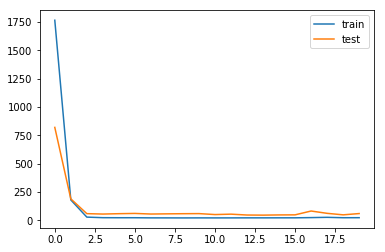

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Stacked LSTM

In [22]:
#params for grid search

p = {'LSTM_n' : [100, 200, 400],
    'LSTM_dropout' : [0, 0.1, 0.2],
    'batch_size' : [30, 60, 90, 120],
}

In [23]:
def LSTM_model(X_train, y_train, X_test, y_test, params):
    model = Sequential()                            
    model.add(LSTM(params['LSTM_n'], activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(BatchNormalization())
    model.add(Dropout(params['LSTM_dropout']))
    model.add(LSTM(params['LSTM_n'], activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(params['LSTM_dropout']))
    model.add(LSTM(params['LSTM_n'], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(params['LSTM_dropout']))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='Adam', 
                  loss='mse')
    print (model.summary())
    
    #Early Stopping to avoid wasting time on bad hyperparams
    es = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

    out = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=1,
                    batch_size=params['batch_size'],
                    callbacks=[es],
                    validation_data=[X_test, y_test])
    
    return out, model

In [24]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

scan_object = talos.Scan(X_train,
                         y_train, 
                         params=p,
                         model=LSTM_model,
                         experiment_name='LSTM',
                         print_params=True)


  0%|          | 0/36 [00:00<?, ?it/s]

{'batch_size': 30, 'LSTM_n': 100, 'LSTM_dropout': 0}
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
l


  3%|▎         | 1/36 [03:57<2:18:17, 237.07s/it]

{'batch_size': 60, 'LSTM_n': 100, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
l

1192/1192 [==============================] - 3s 3ms/step - loss: 25.5739 - val_loss: 16.2588
Epoch 61/100
1192/1192 [==============================] - 3s 3ms/step - loss: 18.8726 - val_loss: 23.9660
Epoch 62/100
1192/1192 [==============================] - 3s 3ms/step - loss: 27.6774 - val_loss: 18.0057
Epoch 63/100
1192/1192 [==============================] - 3s 3ms/step - loss: 18.0480 - val_loss: 39.2423
Epoch 64/100
1192/1192 [==============================] - 3s 3ms/step - loss: 27.7026 - val_loss: 54.1807
Epoch 65/100
1192/1192 [==============================] - 3s 3ms/step - loss: 23.7843 - val_loss: 77.1913
Epoch 66/100
1192/1192 [==============================] - 3s 3ms/step - loss: 20.1358 - val_loss: 17.2841
Epoch 67/100
1192/1192 [==============================] - 3s 3ms/step - loss: 35.4809 - val_loss: 14.8392
Epoch 68/100
1192/1192 [==============================] - 3s 3ms/step - loss: 30.1382 - val_loss: 19.2421
Epoch 69/100
1192/1192 [==============================] - 3


  6%|▌         | 2/36 [09:41<2:32:31, 269.16s/it]

{'batch_size': 90, 'LSTM_n': 100, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
l

1192/1192 [==============================] - 3s 2ms/step - loss: 88.0336 - val_loss: 29.7179
Epoch 60/100
1192/1192 [==============================] - 3s 2ms/step - loss: 81.2206 - val_loss: 53.3021
Epoch 61/100
1192/1192 [==============================] - 3s 2ms/step - loss: 67.5491 - val_loss: 59.2131
Epoch 62/100
1192/1192 [==============================] - 3s 2ms/step - loss: 53.4146 - val_loss: 59.8660
Epoch 63/100
1192/1192 [==============================] - 3s 2ms/step - loss: 48.1601 - val_loss: 77.9111
Epoch 64/100
1192/1192 [==============================] - 3s 2ms/step - loss: 41.4303 - val_loss: 95.7342
Epoch 65/100
1192/1192 [==============================] - 3s 2ms/step - loss: 38.6489 - val_loss: 129.1549
Epoch 66/100
1192/1192 [==============================] - 3s 2ms/step - loss: 30.7954 - val_loss: 64.1120
Epoch 67/100
1192/1192 [==============================] - 3s 2ms/step - loss: 40.9042 - val_loss: 19.2339
Epoch 68/100
1192/1192 [==============================] - 


  8%|▊         | 3/36 [14:27<2:30:54, 274.39s/it]

{'batch_size': 120, 'LSTM_n': 100, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________



 11%|█         | 4/36 [15:32<1:52:45, 211.42s/it]

{'batch_size': 30, 'LSTM_n': 200, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
l


 14%|█▍        | 5/36 [19:21<1:51:57, 216.68s/it]

{'batch_size': 60, 'LSTM_n': 200, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
l

1192/1192 [==============================] - 5s 4ms/step - loss: 27.0593 - val_loss: 196.5800
Epoch 61/100
1192/1192 [==============================] - 5s 4ms/step - loss: 25.1001 - val_loss: 202.8190
Epoch 62/100
1192/1192 [==============================] - 5s 4ms/step - loss: 28.1577 - val_loss: 275.7207
Epoch 63/100
1192/1192 [==============================] - 5s 4ms/step - loss: 25.8346 - val_loss: 170.6243
Epoch 64/100
1192/1192 [==============================] - 5s 4ms/step - loss: 28.1021 - val_loss: 128.1307
Epoch 65/100
1192/1192 [==============================] - 5s 4ms/step - loss: 32.1612 - val_loss: 162.9425
Epoch 66/100
1192/1192 [==============================] - 5s 4ms/step - loss: 32.7052 - val_loss: 178.1358
Epoch 67/100
1192/1192 [==============================] - 5s 4ms/step - loss: 26.1701 - val_loss: 193.3838
Epoch 68/100
1192/1192 [==============================] - 5s 4ms/step - loss: 33.7741 - val_loss: 175.2941
Epoch 69/100
1192/1192 [==========================


 17%|█▋        | 6/36 [26:02<2:16:04, 272.14s/it]

{'batch_size': 90, 'LSTM_n': 200, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
l

1192/1192 [==============================] - 4s 3ms/step - loss: 14.5697 - val_loss: 20.3449
Epoch 61/100
1192/1192 [==============================] - 4s 3ms/step - loss: 24.1607 - val_loss: 30.4686
Epoch 62/100
1192/1192 [==============================] - 4s 3ms/step - loss: 15.2810 - val_loss: 40.6423
Epoch 63/100
1192/1192 [==============================] - 4s 3ms/step - loss: 20.7919 - val_loss: 20.9610
Epoch 64/100
1192/1192 [==============================] - 4s 3ms/step - loss: 15.3254 - val_loss: 50.5710
Epoch 65/100
1192/1192 [==============================] - 4s 3ms/step - loss: 13.5279 - val_loss: 57.4740
Epoch 66/100
1192/1192 [==============================] - 4s 4ms/step - loss: 13.4193 - val_loss: 12.3659
Epoch 67/100
1192/1192 [==============================] - 5s 4ms/step - loss: 24.9513 - val_loss: 15.0489
Epoch 68/100
1192/1192 [==============================] - 4s 3ms/step - loss: 22.0181 - val_loss: 23.8128
Epoch 69/100
1192/1192 [==============================] - 4


 19%|█▉        | 7/36 [33:01<2:32:50, 316.24s/it]

{'batch_size': 120, 'LSTM_n': 200, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________


1192/1192 [==============================] - 4s 3ms/step - loss: 79.3969 - val_loss: 263.2451
Epoch 60/100
1192/1192 [==============================] - 4s 3ms/step - loss: 60.4418 - val_loss: 246.6938
Epoch 61/100
1192/1192 [==============================] - 4s 3ms/step - loss: 54.5532 - val_loss: 158.1124
Epoch 62/100
1192/1192 [==============================] - 4s 3ms/step - loss: 45.5142 - val_loss: 80.9010
Epoch 63/100
1192/1192 [==============================] - 4s 3ms/step - loss: 37.7563 - val_loss: 284.1270
Epoch 64/100
1192/1192 [==============================] - 4s 3ms/step - loss: 36.1806 - val_loss: 17.9896
Epoch 65/100
1192/1192 [==============================] - 4s 3ms/step - loss: 28.5597 - val_loss: 226.2708
Epoch 66/100
1192/1192 [==============================] - 4s 3ms/step - loss: 24.7981 - val_loss: 100.9281
Epoch 67/100
1192/1192 [==============================] - 4s 3ms/step - loss: 22.0844 - val_loss: 41.1699
Epoch 68/100
1192/1192 [=============================


 22%|██▏       | 8/36 [39:39<2:39:00, 340.72s/it]

{'batch_size': 30, 'LSTM_n': 400, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
l


 25%|██▌       | 9/36 [46:06<2:39:32, 354.54s/it]

{'batch_size': 60, 'LSTM_n': 400, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
l


 28%|██▊       | 10/36 [52:44<2:39:18, 367.62s/it]

{'batch_size': 90, 'LSTM_n': 400, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
l


 31%|███       | 11/36 [1:00:38<2:46:26, 399.44s/it]

{'batch_size': 120, 'LSTM_n': 400, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________



 33%|███▎      | 12/36 [1:02:50<2:07:40, 319.17s/it]

{'batch_size': 30, 'LSTM_n': 100, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________


 36%|███▌      | 13/36 [1:05:15<1:42:21, 267.01s/it]

{'batch_size': 60, 'LSTM_n': 100, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________

1192/1192 [==============================] - 2s 2ms/step - loss: 43.5922 - val_loss: 34.0547
Epoch 61/100
1192/1192 [==============================] - 2s 2ms/step - loss: 38.3728 - val_loss: 35.4340
Epoch 62/100
1192/1192 [==============================] - 2s 2ms/step - loss: 42.0215 - val_loss: 26.9984
Epoch 63/100
1192/1192 [==============================] - 2s 2ms/step - loss: 37.6465 - val_loss: 40.3000
Epoch 64/100
1192/1192 [==============================] - 2s 2ms/step - loss: 34.4473 - val_loss: 55.9187
Epoch 65/100
1192/1192 [==============================] - 2s 2ms/step - loss: 41.1509 - val_loss: 30.7003
Epoch 66/100
1192/1192 [==============================] - 2s 2ms/step - loss: 40.3668 - val_loss: 31.3977
Epoch 67/100
1192/1192 [==============================] - 2s 2ms/step - loss: 35.9800 - val_loss: 23.7135
Epoch 68/100
1192/1192 [==============================] - 2s 2ms/step - loss: 38.9054 - val_loss: 30.0020
Epoch 69/100
1192/1192 [==============================] - 2


 39%|███▉      | 14/36 [1:08:43<1:31:26, 249.39s/it]

{'batch_size': 90, 'LSTM_n': 100, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________


 42%|████▏     | 15/36 [1:09:28<1:05:45, 187.90s/it]

{'batch_size': 120, 'LSTM_n': 100, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
________________________________________________________________


 44%|████▍     | 16/36 [1:10:23<49:21, 148.08s/it]  

{'batch_size': 30, 'LSTM_n': 200, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________

1192/1192 [==============================] - 4s 4ms/step - loss: 52.4199 - val_loss: 149.6903
Epoch 61/100
1192/1192 [==============================] - 4s 4ms/step - loss: 56.9382 - val_loss: 40.6136
Epoch 62/100
1192/1192 [==============================] - 4s 4ms/step - loss: 52.1313 - val_loss: 4492.4220
Epoch 63/100
1192/1192 [==============================] - 4s 4ms/step - loss: 55.6916 - val_loss: 3353767035363.9106
Epoch 64/100
1192/1192 [==============================] - 4s 4ms/step - loss: 66.7781 - val_loss: 5102.6776
Epoch 65/100
1192/1192 [==============================] - 4s 4ms/step - loss: 59.8070 - val_loss: 1476.9045
Epoch 66/100
1192/1192 [==============================] - 4s 4ms/step - loss: 58.2221 - val_loss: 111.3314
Epoch 67/100
1192/1192 [==============================] - 4s 4ms/step - loss: 51.9182 - val_loss: 29.9910
Epoch 68/100
1192/1192 [==============================] - 4s 4ms/step - loss: 49.8924 - val_loss: 78018696506119766016.0000
Epoch 69/100
1192/1192


 47%|████▋     | 17/36 [1:16:59<1:10:26, 222.45s/it]

{'batch_size': 60, 'LSTM_n': 200, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________

1192/1192 [==============================] - 3s 2ms/step - loss: 34.5935 - val_loss: 459.8664
Epoch 61/100
1192/1192 [==============================] - 3s 2ms/step - loss: 38.9556 - val_loss: 479.6463
Epoch 62/100
1192/1192 [==============================] - 3s 2ms/step - loss: 36.6586 - val_loss: 431.8625
Epoch 63/100
1192/1192 [==============================] - 3s 2ms/step - loss: 43.9723 - val_loss: 420.7406
Epoch 64/100
1192/1192 [==============================] - 3s 3ms/step - loss: 38.0968 - val_loss: 403.1265
Epoch 65/100
1192/1192 [==============================] - 3s 2ms/step - loss: 51.5050 - val_loss: 418.5983
Epoch 66/100
1192/1192 [==============================] - 3s 2ms/step - loss: 39.1765 - val_loss: 388.4892
Epoch 67/100
1192/1192 [==============================] - 3s 2ms/step - loss: 40.3017 - val_loss: 314.8029
Epoch 68/100
1192/1192 [==============================] - 3s 2ms/step - loss: 35.8965 - val_loss: 274.0657
Epoch 69/100
1192/1192 [==========================


 50%|█████     | 18/36 [1:21:28<1:10:59, 236.62s/it]

{'batch_size': 90, 'LSTM_n': 200, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________


 53%|█████▎    | 19/36 [1:22:29<52:06, 183.91s/it]  

{'batch_size': 120, 'LSTM_n': 200, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
________________________________________________________________


 56%|█████▌    | 20/36 [1:24:12<42:33, 159.58s/it]

{'batch_size': 30, 'LSTM_n': 400, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________

1192/1192 [==============================] - 8s 7ms/step - loss: 49.5934 - val_loss: 349.6043
Epoch 61/100
1192/1192 [==============================] - 9s 7ms/step - loss: 50.1581 - val_loss: 329.6520



 58%|█████▊    | 21/36 [1:32:58<1:07:21, 269.41s/it]

{'batch_size': 60, 'LSTM_n': 400, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________


 61%|██████    | 22/36 [1:38:58<1:09:11, 296.53s/it]

{'batch_size': 90, 'LSTM_n': 400, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________


 64%|██████▍   | 23/36 [1:41:41<55:33, 256.44s/it]  

{'batch_size': 120, 'LSTM_n': 400, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
________________________________________________________________


 67%|██████▋   | 24/36 [1:43:30<42:29, 212.44s/it]

{'batch_size': 30, 'LSTM_n': 100, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________


 69%|██████▉   | 25/36 [1:46:13<36:11, 197.38s/it]

{'batch_size': 60, 'LSTM_n': 100, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________

Epoch 60/100
1192/1192 [==============================] - 2s 2ms/step - loss: 78.8650 - val_loss: 150.2365
Epoch 61/100
1192/1192 [==============================] - 2s 2ms/step - loss: 74.0324 - val_loss: 270.5418
Epoch 62/100
1192/1192 [==============================] - 2s 2ms/step - loss: 62.8353 - val_loss: 110.8421
Epoch 63/100
1192/1192 [==============================] - 2s 2ms/step - loss: 65.3666 - val_loss: 105.4942
Epoch 64/100
1192/1192 [==============================] - 2s 2ms/step - loss: 67.5841 - val_loss: 104.2201
Epoch 65/100
1192/1192 [==============================] - 2s 2ms/step - loss: 69.0065 - val_loss: 99.0920
Epoch 66/100
1192/1192 [==============================] - 2s 2ms/step - loss: 66.5694 - val_loss: 90.3650
Epoch 67/100
1192/1192 [==============================] - 2s 2ms/step - loss: 67.9857 - val_loss: 94.1236
Epoch 68/100
1192/1192 [==============================] - 2s 2ms/step - loss: 69.9498 - val_loss: 93.7895
Epoch 69/100
1192/1192 [=================


 72%|███████▏  | 26/36 [1:49:24<32:35, 195.59s/it]

{'batch_size': 90, 'LSTM_n': 100, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________


 75%|███████▌  | 27/36 [1:50:58<24:46, 165.13s/it]

{'batch_size': 120, 'LSTM_n': 100, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 100)           400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
________________________________________________________________


 78%|███████▊  | 28/36 [1:51:41<17:08, 128.55s/it]

{'batch_size': 30, 'LSTM_n': 200, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________

1192/1192 [==============================] - 5s 4ms/step - loss: 65.7785 - val_loss: 50.2084
Epoch 61/100
1192/1192 [==============================] - 5s 4ms/step - loss: 61.2764 - val_loss: 42.8058
Epoch 62/100
1192/1192 [==============================] - 5s 4ms/step - loss: 67.2363 - val_loss: 53.7207
Epoch 63/100
1192/1192 [==============================] - 5s 4ms/step - loss: 61.7729 - val_loss: 62.7725
Epoch 64/100
1192/1192 [==============================] - 5s 4ms/step - loss: 70.1685 - val_loss: 25.2472
Epoch 65/100
1192/1192 [==============================] - 5s 4ms/step - loss: 49.3655 - val_loss: 51.7182
Epoch 66/100
1192/1192 [==============================] - 5s 4ms/step - loss: 58.9318 - val_loss: 34.1667
Epoch 67/100
1192/1192 [==============================] - 5s 4ms/step - loss: 54.9490 - val_loss: 54.6826
Epoch 68/100
1192/1192 [==============================] - 5s 4ms/step - loss: 57.4617 - val_loss: 44.6226
Epoch 69/100
1192/1192 [==============================] - 5


 81%|████████  | 29/36 [1:58:42<25:13, 216.28s/it]

{'batch_size': 60, 'LSTM_n': 200, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________

1192/1192 [==============================] - 3s 3ms/step - loss: 49.1768 - val_loss: 126.8539
Epoch 61/100
1192/1192 [==============================] - 3s 3ms/step - loss: 51.5893 - val_loss: 142.2939
Epoch 62/100
1192/1192 [==============================] - 3s 2ms/step - loss: 44.2152 - val_loss: 129.3274
Epoch 63/100
1192/1192 [==============================] - 3s 2ms/step - loss: 51.5837 - val_loss: 121.1037
Epoch 64/100
1192/1192 [==============================] - 3s 2ms/step - loss: 51.4955 - val_loss: 153.1312
Epoch 65/100
1192/1192 [==============================] - 3s 2ms/step - loss: 45.1630 - val_loss: 138.6106
Epoch 66/100
1192/1192 [==============================] - 3s 2ms/step - loss: 43.2815 - val_loss: 136.1491
Epoch 67/100
1192/1192 [==============================] - 3s 2ms/step - loss: 41.8545 - val_loss: 116.1814
Epoch 68/100
1192/1192 [==============================] - 3s 2ms/step - loss: 54.8326 - val_loss: 99.8791
Epoch 69/100
1192/1192 [===========================


 83%|████████▎ | 30/36 [2:03:48<24:18, 243.16s/it]

{'batch_size': 90, 'LSTM_n': 200, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________


 86%|████████▌ | 31/36 [2:05:41<17:00, 204.12s/it]

{'batch_size': 120, 'LSTM_n': 200, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 200)           800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
________________________________________________________________


 89%|████████▉ | 32/36 [2:06:40<10:42, 160.62s/it]

{'batch_size': 30, 'LSTM_n': 400, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________


 92%|█████████▏| 33/36 [2:13:34<11:49, 236.62s/it]

{'batch_size': 60, 'LSTM_n': 400, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________


 94%|█████████▍| 34/36 [2:17:54<08:07, 243.61s/it]

{'batch_size': 90, 'LSTM_n': 400, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________

1192/1192 [==============================] - 5s 4ms/step - loss: 46.5937 - val_loss: 244.9909
Epoch 61/100
1192/1192 [==============================] - 5s 4ms/step - loss: 35.7130 - val_loss: 293.2435
Epoch 62/100
1192/1192 [==============================] - 5s 4ms/step - loss: 38.4342 - val_loss: 290.3194
Epoch 63/100
1192/1192 [==============================] - 5s 4ms/step - loss: 35.4312 - val_loss: 262.2355
Epoch 64/100
1192/1192 [==============================] - 5s 4ms/step - loss: 40.0371 - val_loss: 241.0228
Epoch 65/100
1192/1192 [==============================] - 5s 4ms/step - loss: 38.5532 - val_loss: 242.6647
Epoch 66/100
1192/1192 [==============================] - 5s 4ms/step - loss: 36.8070 - val_loss: 261.6396
Epoch 67/100
1192/1192 [==============================] - 5s 4ms/step - loss: 38.0628 - val_loss: 287.4156
Epoch 68/100
1192/1192 [==============================] - 5s 4ms/step - loss: 41.0763 - val_loss: 258.8451
Epoch 69/100
1192/1192 [==========================


 97%|█████████▋| 35/36 [2:26:39<05:28, 328.01s/it]

{'batch_size': 120, 'LSTM_n': 400, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 400)           1600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
________________________________________________________________


100%|██████████| 36/36 [2:28:30<00:00, 247.52s/it]


There is a bug (link below) in the Talos library that means it sorts the columns and values from parameter dictionary incorrectly in the ```talos.Analze``` object. That is why each hyperparameter has unique values so I can easily understand the results.

[https://github.com/autonomio/talos/issues/439]

In [25]:
analyze_object = talos.Analyze(scan_object)
df = analyze_object.data
df.sort_values(by=['val_loss'])

,round_epochs,val_loss,loss,LSTM_dropout,LSTM_n,batch_size
1,100,10.820394,19.600999,60,100,0.0
13,100,12.805731,37.152377,60,100,0.1
7,98,15.786570,14.420242,120,200,0.0
29,100,34.656778,41.152965,60,200,0.2
2,100,42.784797,16.502601,90,100,0.0
0,50,50.788145,35.075523,30,100,0.0
16,87,51.667780,62.586626,30,200,0.1
28,84,60.307169,66.205071,30,200,0.2
6,100,68.828456,18.782989,90,200,0.0
25,86,93.938887,66.418342,60,100,0.2


### Results
* The top 10 results are interesting. They all feature:
  * 100 or 200 as LSTM layer size
  * 